<a href="https://colab.research.google.com/github/Michaelcortes28/Codigo-de-modelo-Double-Exponential-Smoothing-con-Pycaret./blob/main/TARJETAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [ ]:
!pip install pyspark
!pip install --upgrade pycaret
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pycaret.classification import *
from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from pyspark.sql.functions import to_date
#Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')
#importar spark
from pyspark.sql import SparkSession
#Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Read CSV") \
    .getOrCreate()



## Lectura de la base

In [2]:
# Ruta al archivo CSV en Google Drive
file_path_ORIGINAL = '/content/drive/My Drive/BBVA/saldos.csv'
file_path = '/content/drive/My Drive/BBVA/saldoss.csv'

# Leer el archivo CSV usando PySpark
base = spark.read.option("delimiter", ",").csv(file_path, header=True, inferSchema=True).filter((col("cutoff_date") <= "2024-08-01"))

In [3]:
base.show(2,False)

+-----------+--------------------+--------+-------------+-----------+
|cutoff_date|TIPO_PRODUCTO       |PRODUCTO|SALDO_PUNTUAL|SALDO_MEDIO|
+-----------+--------------------+--------+-------------+-----------+
|2022-01-03 |INVERSION GESTIONADA|TARJETAS|2259873394   |2258709676 |
|2022-01-03 |INVERSION GESTIONADA|CONSUMO |4612457730   |4585634444 |
+-----------+--------------------+--------+-------------+-----------+
only showing top 2 rows



In [4]:
s = base.toPandas()
s['cutoff_date'] = pd.to_datetime(s['cutoff_date'])
s['cutoff_date'] = s['cutoff_date'].dt.date
ult_his = s['cutoff_date'].max()
pr_pron = ult_his + pd.Timedelta(days=1)
ult_pron = ult_his + pd.Timedelta(days=30)
fechas_test = sorted([ult_his-pd.Timedelta(days=x) for x in range(30)])
fechas_pronostico = sorted([pr_pron+pd.Timedelta(days=x) for x in range((ult_pron-pr_pron).days+1)])
print("Fechas de pronóstico:", fechas_pronostico)

Fechas de pronóstico: [datetime.date(2024, 8, 2), datetime.date(2024, 8, 3), datetime.date(2024, 8, 4), datetime.date(2024, 8, 5), datetime.date(2024, 8, 6), datetime.date(2024, 8, 7), datetime.date(2024, 8, 8), datetime.date(2024, 8, 9), datetime.date(2024, 8, 10), datetime.date(2024, 8, 11), datetime.date(2024, 8, 12), datetime.date(2024, 8, 13), datetime.date(2024, 8, 14), datetime.date(2024, 8, 15), datetime.date(2024, 8, 16), datetime.date(2024, 8, 17), datetime.date(2024, 8, 18), datetime.date(2024, 8, 19), datetime.date(2024, 8, 20), datetime.date(2024, 8, 21), datetime.date(2024, 8, 22), datetime.date(2024, 8, 23), datetime.date(2024, 8, 24), datetime.date(2024, 8, 25), datetime.date(2024, 8, 26), datetime.date(2024, 8, 27), datetime.date(2024, 8, 28), datetime.date(2024, 8, 29), datetime.date(2024, 8, 30), datetime.date(2024, 8, 31)]




##Tarjetas punta

In [7]:
# Filtrado de datos para tarjetas
tarjetas = base.filter(col("PRODUCTO") == "TARJETAS") \
                .filter(col("cutoff_date") < "2024-02-01") \
                .filter(~col("cutoff_date").isin("2023-07-04", "2023-10-02", "2024-01-02"))

# Conversión de tipos de datos
tarjetasfin = tarjetas.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd")) \
                      .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long")) \
                      .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))

# Obtener fechas mínima y máxima
min_max_dates = tarjetasfin.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates[0]

# Crear rango de fechas
rango_df = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                            .withColumn("cutoff_date", explode("fecha"))

# Unir con datos originales para llenar fechas faltantes
tarjetas_df = rango_df.join(tarjetasfin, "cutoff_date", "left_outer").dropDuplicates()

# Aplicar ventana para rellenar valores faltantes
window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)
tarjetas_completo = tarjetas_df.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec)) \
                               .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))

# Selección y ordenamiento de la columna "SALDO_PUNTUAL"
tarjetas_punta = tarjetas_completo.select("cutoff_date", "SALDO_PUNTUAL").orderBy("cutoff_date")
tarjetas_punta = tarjetas_punta.toPandas()

# Construcción del modelo de predicción
tar = TSForecastingExperiment()
tar = tar.setup(tarjetas_punta['SALDO_PUNTUAL'], fold=3, fh=30, verbose=False)
dt_tar = tar.create_model('br_cds_dt', verbose=False)
nuned_tar = tar.tune_model(dt_tar, verbose=False)

# Predicciones y datos reales
y_pred = tar.predict_model(dt_tar, verbose=False)
y_train = tar.get_config("y_train")
final_tar = tar.finalize_model(nuned_tar)
y_predict = tar.predict_model(final_tar)

# Creación del rango de fechas para predicciones
rango_fechas = pd.date_range(start='2024-02-01', end='2024-03-01', freq='D')
y_predict["cutoff_date"] = rango_fechas
y_predict = y_predict[~y_predict['cutoff_date'].isin(["2024-02-29", "2024-03-01"])]
y_predict = y_predict.rename(columns={'y_pred': 'SALDO_PUNTUAL'})
y_predict = y_predict[['cutoff_date', 'SALDO_PUNTUAL']]

# Base de datos final
tarjetas_ = pd.concat([tarjetas_punta, y_predict], ignore_index=True)
tarjetas_["limite inferior"] = "0"
tarjetas_["limite superior"] = "0"
tarjetas_["Dato"] = "HISTORICO"
tarjetas_['cutoff_date'] = pd.to_datetime(tarjetas_['cutoff_date'])
tarjetas_['cutoff_date'] = tarjetas_['cutoff_date'].dt.date
tarjetas_

,cutoff_date,SALDO_PUNTUAL,limite inferior,limite superior,Dato
0,2022-01-03,2.259873e+09,0,0,HISTORICO
1,2022-01-04,2.260500e+09,0,0,HISTORICO
2,2022-01-05,2.257503e+09,0,0,HISTORICO
3,2022-01-06,2.261220e+09,0,0,HISTORICO
4,2022-01-07,2.266878e+09,0,0,HISTORICO
...,...,...,...,...,...
782,2024-02-24,4.290835e+09,0,0,HISTORICO
783,2024-02-25,4.290673e+09,0,0,HISTORICO
784,2024-02-26,4.308375e+09,0,0,HISTORICO
785,2024-02-27,4.311352e+09,0,0,HISTORICO


## Pronóstico

In [13]:
# Filtramos el producto a trabajar y el rango de tiempo que vamos a tomar después de arreglar la base.
tarjetas_2 = base.filter(col("PRODUCTO") == "TARJETAS")\
                 .filter((col("cutoff_date") > "2024-02-28"))\
                 .filter(~col("cutoff_date").isin(["2023-07-04", "2023-10-02", "2024-01-02"]))

# Especificamos el tipo de dato para cada columna.
tarfin_2 = tarjetas_2.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd"))\
                     .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long"))\
                     .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))

# Realizamos el Forward Fill mediante una ventana de tiempo.
min_max_dates_tar_2 = tarfin_2.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates_tar_2[0]

rango_df_tar_2 = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                                   .withColumn("cutoff_date", F.explode("fecha"))

tarjetas_df_2 = rango_df_tar_2.join(tarfin_2, "cutoff_date", "left_outer").dropDuplicates()

window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)

tarjetas_completo_2 = tarjetas_df_2.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec))\
                                   .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))

tarjetas_punta_2 = tarjetas_completo_2.select("cutoff_date", "SALDO_PUNTUAL").orderBy("cutoff_date")
tarjetas_punta_2 = tarjetas_punta_2.toPandas()

tarjetas_punta_2["Dato"] = "HISTORICO"

# Añadimos el arreglo de la base.
tarjetas_punta_ = pd.concat([tarjetas_, tarjetas_punta_2], ignore_index=True)
tarjetas_punta_['SALDO_PUNTUAL'] = tarjetas_punta_['SALDO_PUNTUAL'].astype('int64')

# Construcción predicción del modelo
tar_2 = TSForecastingExperiment()
tar_2 = tar_2.setup(tarjetas_punta_["SALDO_PUNTUAL"], fold=3, fh=30, verbose=False)

# Elegir el modelo adecuado según los datos históricos
dt_tar_2 = tar_2.create_model('exp_smooth', verbose=False)
tuned_tar_2 = tar_2.tune_model(dt_tar_2, verbose=False)

# Datos que arroja el modelo
y_pred_tar_2 = tar_2.predict_model(dt_tar_2, verbose=False)

# Finalizamos la construcción del modelo
final_tar_2 = tar_2.finalize_model(tuned_tar_2)

# Conjunto de datos de entrenamiento y predicción
y_train_tar_2 = tar_2.get_config("y_train")
y_test_tar_2 = tar_2.get_config("y_test")
y_predict_tar_2 = tar_2.predict_model(final_tar_2)

# Crear base para la predicción
y_predict_tar_2["cutoff_date"] = fechas_pronostico
y_predict_tar_2 = y_predict_tar_2.rename(columns={'y_pred': 'SALDO_PUNTUAL'})
y_predict_tar_2 = y_predict_tar_2[['cutoff_date', 'SALDO_PUNTUAL']]
y_test_tar_2 = pd.DataFrame(y_test_tar_2)

# Crear base de entrenamiento
y_pred_tar_2["cutoff_date"] = fechas_test
y_pred_tar_2["SALDO_PUNTUAL"] = y_pred_tar_2['y_pred'].rename('SALDO_PUNTUAL')
y_pred_tar_2["Dato"] = "HISTORICO"
y_pred_tar_2["Real"] = y_test_tar_2['SALDO_PUNTUAL']
del y_pred_tar_2["y_pred"]

# Crear base de predicciones
y_predict_tar_2['Dato'] = "PRONOSTICO"

# Crear base final
tarjetas_final = pd.concat([tarjetas_, tarjetas_punta_2], ignore_index=True)
tarjetas_final = pd.concat([tarjetas_final, y_predict_tar_2], ignore_index=True)
tarjetas_final['cutoff_date'] = pd.to_datetime(tarjetas_final['cutoff_date'])
tarjetas_final['cutoff_date'] = tarjetas_final['cutoff_date'].dt.date
tarjetas_final['producto'] = "TARJETAS"
tarjetas_final['SALDO_PUNTUAL'] = tarjetas_final['SALDO_PUNTUAL'].astype('int64')
tarjetas_final


,cutoff_date,SALDO_PUNTUAL,limite inferior,limite superior,Dato,producto
0,2022-01-03,2259873394,0,0,HISTORICO,TARJETAS
1,2022-01-04,2260499988,0,0,HISTORICO,TARJETAS
2,2022-01-05,2257502642,0,0,HISTORICO,TARJETAS
3,2022-01-06,2261220107,0,0,HISTORICO,TARJETAS
4,2022-01-07,2266878255,0,0,HISTORICO,TARJETAS
...,...,...,...,...,...,...
967,2024-08-27,4254175902,NaN,NaN,PRONOSTICO,TARJETAS
968,2024-08-28,4252338565,NaN,NaN,PRONOSTICO,TARJETAS
969,2024-08-29,4253966038,NaN,NaN,PRONOSTICO,TARJETAS
970,2024-08-30,4251696406,NaN,NaN,PRONOSTICO,TARJETAS


## Error MAPE

In [15]:
# prompt: haz un codigo en el que calcules el error MAPE siendo que mis y_test_2 son un dataframe con mis valores reales y y_pred_2 una columna de otro dataframe con mis valores futuros

import numpy as np

# Asegúrate de que y_test_2 sea una Serie de pandas y no un DataFrame
y_test_2 = y_test_tar_2['SALDO_PUNTUAL']

# Calcula el MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test_2, y_pred_tar_2['SALDO_PUNTUAL'])
print(f"MAPE: {mape_value}")

MAPE: 0.33608159928753395


## Intervalos de confianza

#### Histograma Valores de pronósticos del modelo.

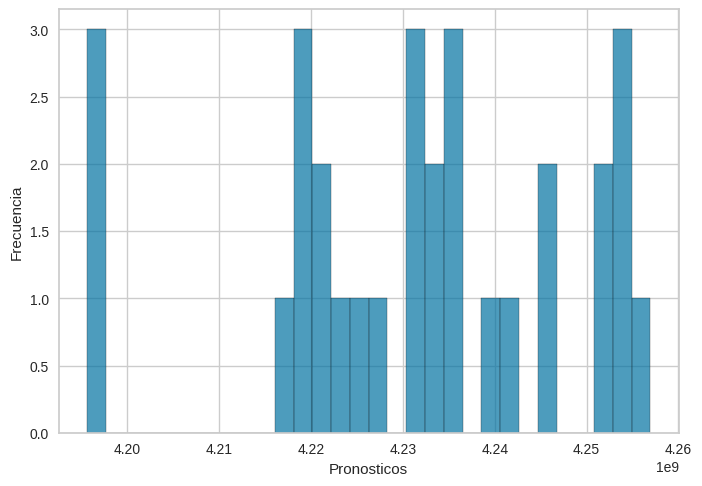

In [16]:
import matplotlib.pyplot as plt

# Supongamos que 'pronosticos' es un array de NumPy con los valores pronosticados
pronosticos = y_predict_tar_2['SALDO_PUNTUAL']
pronosticos = np.array(pronosticos)

# Histograma de los residuos
plt.hist(pronosticos, bins=30, edgecolor='k', alpha=0.7,)
#plt.title('Histograma de Residuos Consumo')
plt.xlabel('Pronosticos')
plt.ylabel('Frecuencia')
# Quita el grid
#plt.grid(False)
#plt.savefig('/content/drive/My Drive/BBVA/consumo_histogram_residuos.pdf')

plt.show()

#### Bootstrap para crear el IC

In [17]:
import numpy as np
from scipy import stats

# Supongamos que 'pronosticos' es un array de NumPy con los valores pronosticados
pronosticos = y_predict_tar_2['SALDO_PUNTUAL']
pronosticos = np.array(pronosticos)

# Parámetros
B = 1000  # Número de muestras bootstrap
n = len(pronosticos)  # Tamaño de la muestra de pronósticos

# Almacenar las estadísticas de las muestras bootstrap
bootstrap_means = np.empty(B)

# Generar muestras bootstrap y calcular la media de cada muestra
for i in range(B):
    sample = np.random.choice(pronosticos, size=n, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Calcular la media y desviación estándar de la distribución bootstrap
mean_bootstrap = np.mean(bootstrap_means)
std_bootstrap = np.std(bootstrap_means)

# Calcular el intervalo de confianza utilizando la distribución normal
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)
lower_bound = mean_bootstrap - z_critical * std_bootstrap
upper_bound = mean_bootstrap + z_critical * std_bootstrap

print(f"Intervalo de confianza del 95% para la media de los pronósticos: [{lower_bound:.4f}, {upper_bound:.4f}]")

Intervalo de confianza del 95% para la media de los pronósticos: [4225433211.5910, 4237124497.7656]


#### Histograma Distribución de medias de pronósticos Bootstrap

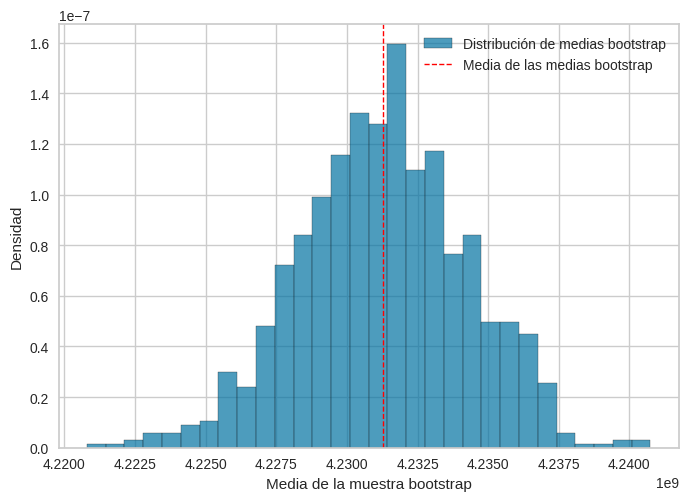

In [18]:
import matplotlib.pyplot as plt

# ... (tu código existente)

# Crear el histograma
plt.hist(bootstrap_means, bins=30,edgecolor='k', density=True, alpha=0.7, label='Distribución de medias bootstrap')

# Agregar una línea vertical para la media de las medias bootstrap
plt.axvline(mean_bootstrap, color='red', linestyle='dashed', linewidth=1, label='Media de las medias bootstrap')

# Personalizar el gráfico
plt.xlabel('Media de la muestra bootstrap')
plt.ylabel('Densidad')
#plt.title('Distribución de las Medias de las Muestras Bootstrap')
plt.legend()
#plt.savefig('/content/drive/My Drive/BBVA/consumo_histogram_residuos_boots.pdf')

# Mostrar el gráfico
plt.show()



##Tarjetas medio

In [19]:
# Filtrar el producto "TARJETAS" y el rango de fechas requerido
tarjetas = base.filter(col("PRODUCTO") == "TARJETAS") \
               .filter(col("cutoff_date") < "2024-02-01") \
               .filter(~col("cutoff_date").isin("2023-07-04", "2023-10-02", "2024-01-02", "2023-04-03", "2023-05-23", "2023-05-29", "2023-02-27", "2023-04-26", "2023-04-27", "2023-04-28"))

# Preparar datos para `SALDO_MEDIO`
tarfin = tarjetas.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd")) \
                 .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long")) \
                 .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))

# Obtener fechas mínimas y máximas
min_max_dates_tar = tarfin.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates_tar[0]

# Crear rango de fechas
rango_df_tar = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                                .withColumn("cutoff_date", explode("fecha"))

# Unir con datos históricos
tarjetas_df = rango_df_tar.join(tarfin, "cutoff_date", "left_outer").dropDuplicates()

# Definir la ventana de datos
window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)

# Completar datos con el último valor disponible
tarjetas_completo = tarjetas_df.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec)) \
                               .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))

# Seleccionar y ordenar `SALDO_MEDIO`
tarjetas_medio = tarjetas_completo.select("cutoff_date", "SALDO_MEDIO").orderBy("cutoff_date")

# Convertir a pandas
tarjetas_medio = tarjetas_medio.toPandas()

# Construcción del modelo de predicción para `SALDO_MEDIO`
tar = TSForecastingExperiment()
tar = tar.setup(tarjetas_medio['SALDO_MEDIO'], fold=3, fh=30, verbose=False)

# Escoger modelo
# tar_mod = tar.compare_models(n_select=3, sort="MAE")
# Crear el modelo escogido
dt_tar = tar.create_model('br_cds_dt', verbose=False)

# Mejorar los hiperparámetros
tuned_tar = tar.tune_model(dt_tar, verbose=False)

# Datos del modelo
y_pred_tar = tar.predict_model(dt_tar, verbose=False)

# Datos reales
y_train_tar = tar.get_config("y_train")

# Finalizar la construcción del modelo
final_tar = tar.finalize_model(tuned_tar)

# Conjunto de predicción
y_predict_tar = tar.predict_model(final_tar)

# Crear base de predicciones
rango_fechas_tar = pd.date_range(start='2024-02-01', end='2024-03-01', freq='D')
y_predict_tar["cutoff_date"] = rango_fechas_tar
y_predict_tar = y_predict_tar[~y_predict_tar['cutoff_date'].isin(["2024-02-29", "2024-03-01"])]
y_predict_tar = y_predict_tar.rename(columns={'y_pred': 'SALDO_MEDIO'})
y_predict_tar = y_predict_tar[['cutoff_date', 'SALDO_MEDIO']]

# Crear base de datos con los datos históricos y predicciones
tarjetas__ = pd.concat([tarjetas_medio, y_predict_tar], ignore_index=True)
tarjetas__["Dato"] = "HISTORICO"
tarjetas__['cutoff_date'] = pd.to_datetime(tarjetas__['cutoff_date'])
tarjetas__['cutoff_date'] = tarjetas__['cutoff_date'].dt.date
tarjetas__

,cutoff_date,SALDO_MEDIO,Dato
0,2022-01-03,2.258710e+09,HISTORICO
1,2022-01-04,2.259157e+09,HISTORICO
2,2022-01-05,2.258826e+09,HISTORICO
3,2022-01-06,2.259225e+09,HISTORICO
4,2022-01-07,2.260319e+09,HISTORICO
...,...,...,...
782,2024-02-24,4.366340e+09,HISTORICO
783,2024-02-25,4.372581e+09,HISTORICO
784,2024-02-26,4.378360e+09,HISTORICO
785,2024-02-27,4.382435e+09,HISTORICO


## Pronostico

In [20]:
# Filtramos el producto "TARJETAS" y el rango de fechas requerido
tarjetas_2 = base.filter(col("PRODUCTO") == "TARJETAS") \
                 .filter((col("cutoff_date") > "2024-02-28")) \
                 .filter(~col("cutoff_date").isin(["2023-07-04", "2023-10-02", "2024-01-02", "2023-04-03", "2023-05-23", "2023-05-29", "2023-02-27", "2023-04-26", "2023-04-27", "2023-04-28"]))

# Especificamos el tipo de dato para cada columna.
tarfin_2 = tarjetas_2.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd")) \
                     .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long")) \
                     .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))

# Obtener fechas mínimas y máximas
min_max_dates_tar_2 = tarfin_2.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates_tar_2[0]

# Crear rango de fechas
rango_df_tar_2 = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                                  .withColumn("cutoff_date", F.explode("fecha"))

# Unir con datos históricos
tarjetas_df_2 = rango_df_tar_2.join(tarfin_2, "cutoff_date", "left_outer").dropDuplicates()

# Definir la ventana de datos
window_spec_tar = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)

# Completar datos con el último valor disponible
tarjetas_completo_2 = tarjetas_df_2.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec_tar)) \
                                   .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec_tar))

# Seleccionar y ordenar `SALDO_MEDIO`
tarjetas_medio_2 = tarjetas_completo_2.select("cutoff_date", "SALDO_MEDIO").orderBy("cutoff_date")

# Convertir a pandas
tarjetas_medio_2 = tarjetas_medio_2.toPandas()
tarjetas_medio_2["Dato"] = "HISTORICO"
tarjetas_medio_ = pd.concat([tarjetas__, tarjetas_medio_2], ignore_index=True)
tarjetas_medio_['SALDO_MEDIO'] = tarjetas_medio_['SALDO_MEDIO'].astype('int64')

# Construcción del modelo de predicción para `SALDO_MEDIO`
tar_2 = TSForecastingExperiment()
tar_2 = tar_2.setup(tarjetas_medio_["SALDO_MEDIO"], fold=3, fh=30, verbose=False)

# Crear el modelo escogido
dt_tar_2 = tar_2.create_model('exp_smooth', verbose=False)
# Mejorar los hiperparámetros
tuned_tar_2 = tar_2.tune_model(dt_tar_2, verbose=False)

# Datos del modelo
y_pred_tar_2 = tar_2.predict_model(dt_tar_2, verbose=False)
# Finalizar la construcción del modelo
final_tar_2 = tar_2.finalize_model(tuned_tar_2)

# Conjunto de predicción
y_train_tar_2 = tar_2.get_config("y_train")
y_test_tar_2 = tar_2.get_config("y_test")
y_predict_tar_2 = tar_2.predict_model(final_tar_2)

# Crear base para la predicción
y_predict_tar_2["cutoff_date"] = fechas_pronostico
y_predict_tar_2 = y_predict_tar_2.rename(columns={'y_pred': 'SALDO_MEDIO'})
y_predict_tar_2 = y_predict_tar_2[['cutoff_date', 'SALDO_MEDIO']]

# Intervalos de confianza y residuos
y_test_tar_2 = pd.DataFrame(y_test_tar_2)
residuos_tar_2 = tarjetas_medio_["SALDO_MEDIO"] - y_pred_tar_2['y_pred']
residuos_tar_2 = residuos_tar_2.dropna()

# Crear base de entrenamiento
y_pred_tar_2["cutoff_date"] = fechas_test
y_pred_tar_2["SALDO_MEDIO"] = y_pred_tar_2['y_pred'].rename('SALDO_MEDIO')
y_pred_tar_2["Dato"] = "HISTORICO"
y_pred_tar_2["Real"] = y_test_tar_2['SALDO_MEDIO']
del y_pred_tar_2["y_pred"]

# Crear base de predicciones
y_predict_tar_2['Dato'] = "PRONOSTICO"

# Crear base final
tarjetas_final_ = pd.concat([tarjetas__, tarjetas_medio_2], ignore_index=True)
tarjetas_final_ = pd.concat([tarjetas_final_, y_predict_tar_2], ignore_index=True)
tarjetas_final_['cutoff_date'] = pd.to_datetime(tarjetas_final_['cutoff_date'])
tarjetas_final_['cutoff_date'] = tarjetas_final_['cutoff_date'].dt.date
tarjetas_final_['producto'] = "TARJETAS"
tarjetas_final_['SALDO_MEDIO'] = tarjetas_final_['SALDO_MEDIO'].astype('int64')
tarjetas_final_

,cutoff_date,SALDO_MEDIO,Dato,producto
0,2022-01-03,2258709676,HISTORICO,TARJETAS
1,2022-01-04,2259157290,HISTORICO,TARJETAS
2,2022-01-05,2258826360,HISTORICO,TARJETAS
3,2022-01-06,2259225317,HISTORICO,TARJETAS
4,2022-01-07,2260318594,HISTORICO,TARJETAS
...,...,...,...,...
967,2024-08-27,4252430150,PRONOSTICO,TARJETAS
968,2024-08-28,4253668526,PRONOSTICO,TARJETAS
969,2024-08-29,4255828716,PRONOSTICO,TARJETAS
970,2024-08-30,4254409945,PRONOSTICO,TARJETAS


## Error MAPE


In [23]:
# prompt: haz un codigo en el que calcules el error MAPE siendo que mis y_test_2 son un dataframe con mis valores reales y y_pred_2 una columna de otro dataframe con mis valores futuros

import numpy as np

# Asegúrate de que y_test_2 sea una Serie de pandas y no un DataFrame
y_test_2 = y_test_tar_2['SALDO_MEDIO']

# Calcula el MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test_2, y_pred_tar_2['SALDO_MEDIO'])
print(f"MAPE: {mape_value}")

MAPE: 0.9537149072628565


## Intervalos de confianza

In [24]:
import numpy as np
from scipy import stats

# Supongamos que 'pronosticos' es un array de NumPy con los valores pronosticados
pronosticos = y_predict_tar_2['SALDO_MEDIO']
pronosticos = np.array(pronosticos)

# Parámetros
B = 1000  # Número de muestras bootstrap
n = len(pronosticos)  # Tamaño de la muestra de pronósticos

# Almacenar las estadísticas de las muestras bootstrap
bootstrap_means = np.empty(B)

# Generar muestras bootstrap y calcular la media de cada muestra
for i in range(B):
    sample = np.random.choice(pronosticos, size=n, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Calcular la media y desviación estándar de la distribución bootstrap
mean_bootstrap = np.mean(bootstrap_means)
std_bootstrap = np.std(bootstrap_means)

# Calcular el intervalo de confianza utilizando la distribución normal
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)
lower_bound = mean_bootstrap - z_critical * std_bootstrap
upper_bound = mean_bootstrap + z_critical * std_bootstrap

print(f"Intervalo de confianza del 95% para la media de los pronósticos: [{lower_bound:.4f}, {upper_bound:.4f}]")

Intervalo de confianza del 95% para la media de los pronósticos: [4225116418.1438, 4238681385.9100]


# Gráfico Ponóstico Series de tiempo para ambos saldos.

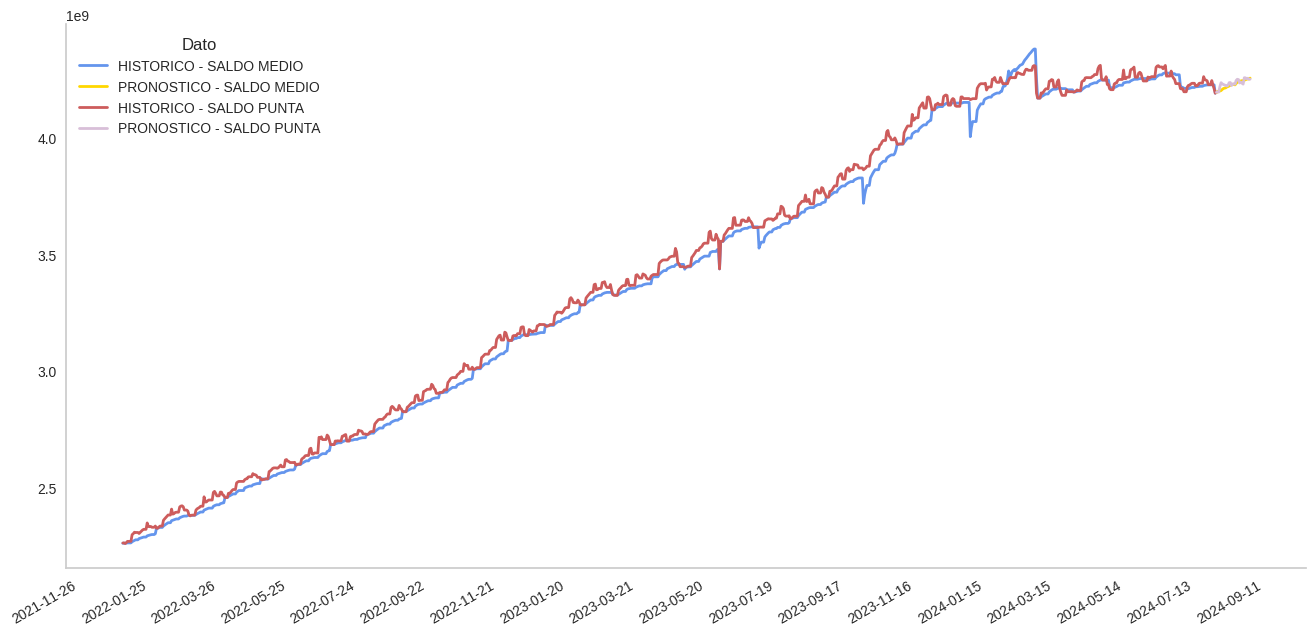

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ajusta el índice de los DataFrames
tarjetas_final.set_index('cutoff_date', inplace=True)
tarjetas_final_.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores_tarjetas = {'HISTORICO': 'cornflowerblue', 'PRONOSTICO': 'gold'}
colores_tarjetas_ = {'HISTORICO': 'indianred', 'PRONOSTICO': 'thistle'}

# Crea una nueva figura
plt.figure(figsize=(16, 8))

# Grafica SALDO_MEDIO para cada tipo de dato
for Dato, color in colores_tarjetas.items():
    subset = tarjetas_final_[tarjetas_final_['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_MEDIO'], label=f'{Dato} - SALDO MEDIO', color=color, linewidth=2)

# Grafica SALDO_PUNTUAL para cada tipo de dato
for Dato, color in colores_tarjetas_.items():
    subset = tarjetas_final[tarjetas_final['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_PUNTUAL'], label=f'{Dato} - SALDO PUNTA', color=color, linewidth=2)

# Establece el formato de las fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar solo algunas fechas (cada 60 días en este caso)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()

# Ajusta el rango del eje x para que empiece desde el 1 de enero de 2023
#plt.xlim(pd.Timestamp('2023-01-01'), plt.gca().get_xlim()[1])

# Añade detalles al gráfico
#plt.title('SALDOS TARJETAS')
#plt.xlabel('Fecha')
#plt.ylabel('Saldo')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico
plt.savefig('/content/drive/My Drive/BBVA/TARJETAS_combinado.pdf')

# Muestra el gráfico
plt.show()


### Rendimiento-PUNTA

In [ ]:
# Lectura de archivos CSV
abril = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_abril_T.csv', header=True, inferSchema=True)
mayo = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_mayo_T.csv', header=True, inferSchema=True)
junio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_junio_T.csv', header=True, inferSchema=True)
julio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_julio_T.csv', header=True, inferSchema=True)
agosto = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_agosto_T.csv', header=True, inferSchema=True)

# Unir todos los DataFrames y filtrar las fechas posteriores a "2024-03-31"
a = abril.union(mayo)
a = a.union(junio)
a = a.union(julio)
a = a.union(agosto)
a = a.filter(col("cutoff_date")>"2024-03-31").dropDuplicates(["cutoff_date","SALDO_PUNTUAL","Dato"])
# Obtener la fecha mínima y máxima
min_fecha = a.agg(F.min("cutoff_date")).first()[0]
max_fecha = a.agg(F.max("cutoff_date")).first()[0]
# Generar un rango completo de fechas
rango_fechas = spark.sql(f"SELECT explode(sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day)) as cutoff_date")
# Crear un DataFrame con todas las combinaciones posibles de fechas, productos y 'Dato'
df_completo = a.select("Dato", "producto").distinct().crossJoin(rango_fechas)
df_completo = df_completo.join(a, on=["cutoff_date","Dato", "producto"], how="left")
window_spec = Window.partitionBy("Dato", "producto").orderBy("cutoff_date")
df_final = df_completo.withColumn("SALDO_PUNTUAL", when(col("SALDO_PUNTUAL").isNull(), lead("SALDO_PUNTUAL", 1).over(window_spec)).otherwise(col("SALDO_PUNTUAL")))
df_final = df_final.select("cutoff_date","SALDO_PUNTUAL","Dato","producto")
df_final.show()

+-----------+-------------+---------+--------+
|cutoff_date|SALDO_PUNTUAL|     Dato|producto|
+-----------+-------------+---------+--------+
| 2024-04-01|   4197320950|HISTORICO|TARJETAS|
| 2024-04-02|   4198443237|HISTORICO|TARJETAS|
| 2024-04-03|   4202147892|HISTORICO|TARJETAS|
| 2024-04-04|   4206818942|HISTORICO|TARJETAS|
| 2024-04-05|   4203833046|HISTORICO|TARJETAS|
| 2024-04-06|   4203833046|HISTORICO|TARJETAS|
| 2024-04-07|   4203833046|HISTORICO|TARJETAS|
| 2024-04-08|   4240503206|HISTORICO|TARJETAS|
| 2024-04-09|   4246050532|HISTORICO|TARJETAS|
| 2024-04-10|   4246879633|HISTORICO|TARJETAS|
| 2024-04-11|   4258239231|HISTORICO|TARJETAS|
| 2024-04-12|   4259565257|HISTORICO|TARJETAS|
| 2024-04-13|   4259565257|HISTORICO|TARJETAS|
| 2024-04-14|   4259565257|HISTORICO|TARJETAS|
| 2024-04-15|   4259851934|HISTORICO|TARJETAS|
| 2024-04-16|   4259092383|HISTORICO|TARJETAS|
| 2024-04-17|   4264021105|HISTORICO|TARJETAS|
| 2024-04-18|   4266430261|HISTORICO|TARJETAS|
| 2024-04-19|

In [ ]:
# Pivotar el DataFrame
df_final_1 = df_final.groupBy(["cutoff_Date","producto"]).pivot("Dato").agg(F.first("SALDO_PUNTUAL")).orderBy("cutoff_date").fillna(0)

df_final_1= df_final_1.withColumn("Precision", col("PRONOSTICO") - col("HISTORICO"))
df_final_1 = df_final_1.toPandas()
df_final_1['HISTORICO']=df_final_1['HISTORICO'].astype('int64')
df_final_1['Precision']=df_final_1['Precision'].astype('int64')
sal_1 = '/content/drive/My Drive/BBVA/saldos_rendimiento/rendimiento_saldos_abril.csv'
df_final_1.to_csv(sal_1, index=False)

In [ ]:
df_final_1

,cutoff_Date,producto,HISTORICO,PRONOSTICO,Precision
0,2024-04-01,TARJETAS,4197320950,4190093237,-7227713
1,2024-04-02,TARJETAS,4198443237,4189745214,-8698023
2,2024-04-03,TARJETAS,4202147892,4190008999,-12138893
3,2024-04-04,TARJETAS,4206818942,4189739546,-17079396
4,2024-04-05,TARJETAS,4203833046,4205583336,1750290
...,...,...,...,...,...
148,2024-08-27,TARJETAS,0,4245989544,4245989544
149,2024-08-28,TARJETAS,0,4244150447,4244150447
150,2024-08-29,TARJETAS,0,4245639755,4245639755
151,2024-08-30,TARJETAS,0,4243250597,4243250597


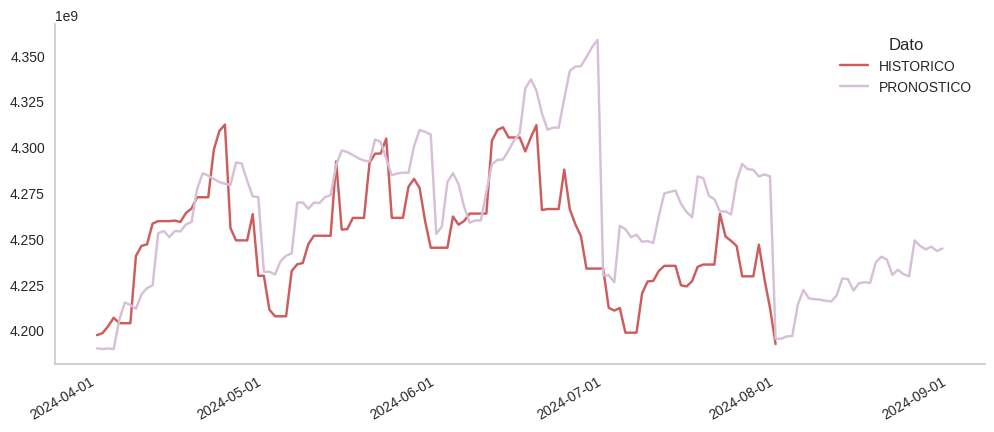

In [ ]:
# Filtrar el dataset para "TARJETAS"
df_tarjetas = df_final.filter(col("producto") == "TARJETAS")
df_tarjetas = df_tarjetas.toPandas()

# Convertir la columna 'cutoff_date' a tipo de dato datetime si aún no está convertido
df_tarjetas['cutoff_date'] = pd.to_datetime(df_tarjetas['cutoff_date'])

# Configura el índice para el DataFrame
df_tarjetas.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores = {'HISTORICO': 'indianred', 'PRONOSTICO': 'thistle'}

# Crea una nueva figura
plt.figure(figsize=(12, 5))

# Grafica cada tipo de dato con su color correspondiente
for Dato, color in colores.items():
    subset = df_tarjetas[df_tarjetas['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_PUNTUAL'], label=Dato, color=color)

# Añade detalles al gráfico
# plt.title('Saldo Puntual por Tipo de Dato para TARJETAS')
# plt.xlabel('Fecha')
# plt.ylabel('Saldo')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Establece el formato de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar algunas fechas claramente (cada 2 meses en este caso)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico como un archivo PDF
plt.savefig('/content/drive/My Drive/BBVA/Rendimiento_TARJETAS_punta.pdf')

# Muestra el gráfico
plt.show()


## RENDIMIENTO-Medio

In [ ]:
# Lectura de archivos CSV
abril = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_abril_T.csv', header=True, inferSchema=True)
mayo = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_mayo_T.csv', header=True, inferSchema=True)
junio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_junio_T.csv', header=True, inferSchema=True)
julio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_julio_T.csv', header=True, inferSchema=True)
agosto = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_agosto_T.csv', header=True, inferSchema=True)

# Unir todos los DataFrames y filtrar las fechas posteriores a "2024-03-31"
a = abril.union(mayo)
a = a.union(junio)
a = a.union(julio)
a = a.union(agosto)
a = a.filter(col("cutoff_date")>"2024-03-31").dropDuplicates(["cutoff_date","SALDO_MEDIO","Dato"])
# Obtener la fecha mínima y máxima
min_fecha = a.agg(F.min("cutoff_date")).first()[0]
max_fecha = a.agg(F.max("cutoff_date")).first()[0]
# Generar un rango completo de fechas
rango_fechas = spark.sql(f"SELECT explode(sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day)) as cutoff_date")
# Crear un DataFrame con todas las combinaciones posibles de fechas, productos y 'Dato'
df_completo = a.select("Dato", "producto").distinct().crossJoin(rango_fechas)
df_completo = df_completo.join(a, on=["cutoff_date","Dato", "producto"], how="left")
window_spec = Window.partitionBy("Dato", "producto").orderBy("cutoff_date")
df_final = df_completo.withColumn("SALDO_MEDIO", when(col("SALDO_MEDIO").isNull(), lead("SALDO_MEDIO", 1).over(window_spec)).otherwise(col("SALDO_MEDIO")))
df_final = df_final.select("cutoff_date","SALDO_MEDIO","Dato","producto")
df_final.show()

+-----------+-----------+---------+--------+
|cutoff_date|SALDO_MEDIO|     Dato|producto|
+-----------+-----------+---------+--------+
| 2024-04-01| 4197320950|HISTORICO|TARJETAS|
| 2024-04-02| 4197882093|HISTORICO|TARJETAS|
| 2024-04-03| 4199304026|HISTORICO|TARJETAS|
| 2024-04-04| 4201182755|HISTORICO|TARJETAS|
| 2024-04-05| 4201712813|HISTORICO|TARJETAS|
| 2024-04-06| 4201712813|HISTORICO|TARJETAS|
| 2024-04-07| 4201712813|HISTORICO|TARJETAS|
| 2024-04-08| 4207091670|HISTORICO|TARJETAS|
| 2024-04-09| 4211420431|HISTORICO|TARJETAS|
| 2024-04-10| 4214966352|HISTORICO|TARJETAS|
| 2024-04-11| 4218900249|HISTORICO|TARJETAS|
| 2024-04-12| 4222289000|HISTORICO|TARJETAS|
| 2024-04-13| 4222289000|HISTORICO|TARJETAS|
| 2024-04-14| 4222289000|HISTORICO|TARJETAS|
| 2024-04-15| 4229763362|HISTORICO|TARJETAS|
| 2024-04-16| 4231596426|HISTORICO|TARJETAS|
| 2024-04-17| 4233503759|HISTORICO|TARJETAS|
| 2024-04-18| 4235333009|HISTORICO|TARJETAS|
| 2024-04-19| 4237295026|HISTORICO|TARJETAS|
| 2024-04-

In [ ]:
# Pivotar el DataFrame
df_final_1 = df_final.groupBy(["cutoff_Date","producto"]).pivot("Dato").agg(F.first("SALDO_MEDIO")).orderBy("cutoff_date").fillna(0)

df_final_1= df_final_1.withColumn("Precision", col("PRONOSTICO") - col("HISTORICO"))
df_final_1 = df_final_1.toPandas()
df_final_1['HISTORICO']=df_final_1['HISTORICO'].astype('int64')
df_final_1['Precision']=df_final_1['Precision'].astype('int64')
sal_1 = '/content/drive/My Drive/BBVA/saldos_rendimiento/rendimiento_saldos_abril_MEDIO.csv'
df_final_1.to_csv(sal_1, index=False)
df_final_1

,cutoff_Date,producto,HISTORICO,PRONOSTICO,Precision
0,2024-04-01,TARJETAS,4197320950,4210292138,12971188
1,2024-04-02,TARJETAS,4197882093,4212802231,14920138
2,2024-04-03,TARJETAS,4199304026,4216476954,17172928
3,2024-04-04,TARJETAS,4201182755,4220761399,19578644
4,2024-04-05,TARJETAS,4201712813,4223884098,22171285
...,...,...,...,...,...
148,2024-08-27,TARJETAS,0,4252430151,4252430151
149,2024-08-28,TARJETAS,0,4253668527,4253668527
150,2024-08-29,TARJETAS,0,4255828717,4255828717
151,2024-08-30,TARJETAS,0,4254409946,4254409946


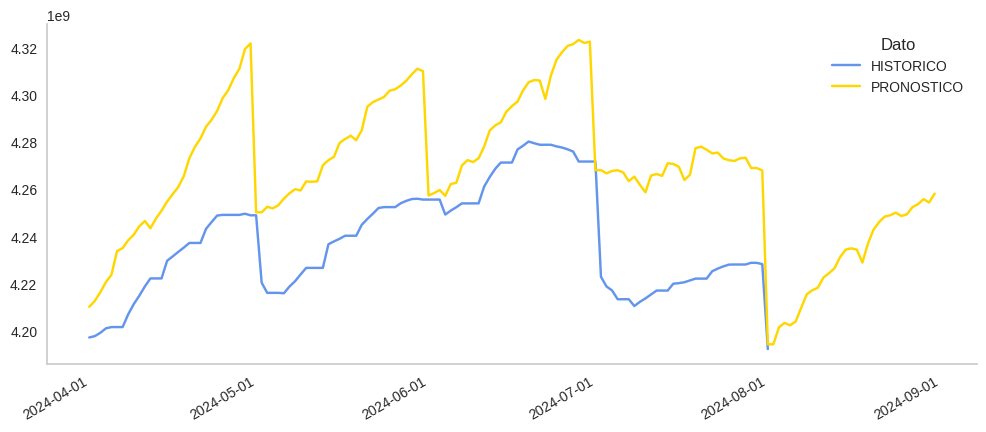

In [ ]:
# Filtrar el dataset para "TARJETAS"
df_tarjetas = df_final.filter(col("producto") == "TARJETAS")
df_tarjetas = df_tarjetas.toPandas()

# Convertir la columna 'cutoff_date' a tipo de dato datetime si aún no está convertido
df_tarjetas['cutoff_date'] = pd.to_datetime(df_tarjetas['cutoff_date'])

# Configura el índice para el DataFrame
df_tarjetas.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores = {'HISTORICO': 'cornflowerblue', 'PRONOSTICO': 'gold'}

# Crea una nueva figura
plt.figure(figsize=(12, 5))

# Grafica cada tipo de dato con su color correspondiente
for Dato, color in colores.items():
    subset = df_tarjetas[df_tarjetas['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_MEDIO'], label=Dato, color=color)

# Añade detalles al gráfico
# plt.title('Saldo Medio por Tipo de Dato para TARJETAS')
# plt.xlabel('Fecha')
# plt.ylabel('Saldo Medio')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Establece el formato de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar algunas fechas claramente (cada 2 meses en este caso)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico como un archivo PDF
plt.savefig('/content/drive/My Drive/BBVA/Rendimiento_TARJETAS_medio.pdf')

# Muestra el gráfico
plt.show()
